# 1. Librerías


In [844]:
# Datos
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas de evaluación
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelos a Entrenar
import xgboost as xgb

# inhabilita warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Load Data

In [845]:
df = pd.read_csv('C:/Users/aalei/Desktop/GITHUB_DQ/clean_data.csv')
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1])
df.head(2)

Rows:  14484   Columns:  8


,date,id,region,store,category,item,price,sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0


In [846]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# 3. Feature Engineering

In [847]:
# Variables temporales
df['day'] = df['date'].dt.day
df['cumulative_month'] = (df['date'].dt.year - 2013) * 12 + df['date'].dt.month
df.head(2)

,date,id,region,store,category,item,price,sales,day,cumulative_month
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,1
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,2


In [848]:
# Revenue y lag_1 de revenue
df['revenue']= df['sales'] * df['price']
df['id_revenue_mean_lag_1'] = df.groupby(["id"])["revenue"].transform(lambda series: series.shift(2))

In [849]:
df1 = df[df['date'] < '2015-10-01'] # Quitar el mes de octubre que tiene algunos datos, pero es el mes que se busca predecir.

# Función para crear lags de variables agrupadas
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,resample_value):
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample(resample_value)[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
    gb_df_[f"{new_name}_lag_1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb_df_[f"{new_name}_lag_2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    gb_df_[f"{new_name}_lag_3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3)
    )
    gb_df_[f"{new_name}_lag_4"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(4)
    )
    print(f"Plus 3 lags features for: {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [850]:
# TARGET: SALES
print(f'Dimensión inicial df: {df.shape}')

# store/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# region/store
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["region","store"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["region","store"], how = "left")

# store/category
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","category"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","category"], how = "left")

# category/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["category","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='2M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["category","item"], how = "left")

# region/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["region","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["region","item"], how = "left")

# region/category -> EMPEORA LEVEMENTE EL RMSE
'''vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["region","category"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["region","category"], how = "left")'''

print(f'Dimensión final df: {df.shape}')
df.head()

Dimensión inicial df: (14484, 12)
Plus 3 lags features for: store_item_sales_sum
Plus 3 lags features for: region_store_sales_sum
Plus 3 lags features for: store_category_sales_sum
Plus 3 lags features for: category_item_sales_sum
Plus 3 lags features for: region_item_sales_sum
Dimensión final df: (14484, 32)


,date,id,region,store,category,item,price,sales,day,cumulative_month,...,store_category_sales_sum_lag_3,store_category_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,3,...,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,5,...,NaN,NaN,57.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN


In [851]:
# TARGET: REVENUE
print(f'Dimensión inicial df: {df.shape}')

# store/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","item"],
    target_column = "revenue",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

print(f'Dimensión final df: {df.shape}')
df.head()

Dimensión inicial df: (14484, 32)
Plus 3 lags features for: store_item_revenue_sum
Dimensión final df: (14484, 36)


,date,id,region,store,category,item,price,sales,day,cumulative_month,...,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,4,...,NaN,NaN,30.0,NaN,NaN,NaN,45345.378788,NaN,NaN,NaN
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [852]:
# TARGET: PRICE
'''print(f'Dimensión inicial df: {df.shape}')

# store/item
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["store","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='3M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# Promedio de ventas agrupadas por item y evento
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["id","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")

print(f'Dimensión final df: {df.shape}')
df.head()'''

Dimensión inicial df: (14484, 36)
Plus 3 lags features for: store_item_price_mean


'# Promedio de ventas agrupadas por item y evento\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = ["id","item"],\n    target_column = "price",\n    agg_func = np.mean,\n    agg_func_name = "mean",\n    resample_value=\'M\')\ndf = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")\n\nprint(f\'Dimensión final df: {df.shape}\')\ndf.head()'

# Borrar features que no serán parte del modelo

In [853]:
COLUMNS_TO_DROP = ["revenue"] 
df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [854]:
print(df.columns)

Index(['date', 'id', 'region', 'store', 'category', 'item', 'price', 'sales',
       'day', 'cumulative_month', 'id_revenue_mean_lag_1',
       'store_item_sales_sum_lag_1', 'store_item_sales_sum_lag_2',
       'store_item_sales_sum_lag_3', 'store_item_sales_sum_lag_4',
       'region_store_sales_sum_lag_1', 'region_store_sales_sum_lag_2',
       'region_store_sales_sum_lag_3', 'region_store_sales_sum_lag_4',
       'store_category_sales_sum_lag_1', 'store_category_sales_sum_lag_2',
       'store_category_sales_sum_lag_3', 'store_category_sales_sum_lag_4',
       'category_item_sales_sum_lag_1', 'category_item_sales_sum_lag_2',
       'category_item_sales_sum_lag_3', 'category_item_sales_sum_lag_4',
       'region_item_sales_sum_lag_1', 'region_item_sales_sum_lag_2',
       'region_item_sales_sum_lag_3', 'region_item_sales_sum_lag_4',
       'store_item_revenue_sum_lag_1', 'store_item_revenue_sum_lag_2',
       'store_item_revenue_sum_lag_3', 'store_item_revenue_sum_lag_4',
       'sto

In [855]:
df.set_index("id", inplace = True)
df.sample(3)

,date,region,store,category,item,price,sales,day,cumulative_month,id_revenue_mean_lag_1,...,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4,store_item_price_mean_lag_1,store_item_price_mean_lag_2,store_item_price_mean_lag_3,store_item_price_mean_lag_4
id,,,,,,,,,,,,,,,,,,,,,
31_10331,2015-01-31,7,31,40,10331,149.0,5.0,31,25,894.0,...,5.0,10.0,1639.0,596.000000,745.0,1490.0,149.0,149.000000,149.0,149.0
58_6185,2015-04-30,22,58,30,6185,499.0,5.0,30,28,2495.0,...,28.0,31.0,7485.0,8981.657143,6487.0,3992.0,499.0,498.985714,499.0,499.0
25_7894,2013-12-31,7,25,6,7894,1490.0,26.0,31,12,40230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Train Test Split

In [856]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [857]:
X_train = df[df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['sales']

X_valida = df[df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['sales']

X_test = df[df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['sales']

In [858]:
print(f'Train shape: {X_train.shape}, Valida shape: {X_valida.shape}, Test shape: {X_test.shape}')

Train shape: (13632, 36), Valida shape: (426, 36), Test shape: (426, 36)


In [859]:
X_train.head(2)

,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,...,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4,store_item_price_mean_lag_1,store_item_price_mean_lag_2,store_item_price_mean_lag_3,store_item_price_mean_lag_4
id,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,31,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,28,2,NaN,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [860]:
X_test.head(2)

,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,...,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4,store_item_price_mean_lag_1,store_item_price_mean_lag_2,store_item_price_mean_lag_3,store_item_price_mean_lag_4
id,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,0.0,31,34,24312.785714,NaN,NaN,...,73.0,26.0,40284.562984,67474.082560,69078.742424,23892.619048,969.998385,1339.886776,979.404082,894.206349
12_11369,16,12,9,11369,0.0,31,34,21881.300000,NaN,NaN,...,90.0,90.0,82573.214432,84963.898506,64727.773614,104473.842204,917.480160,944.043317,719.197485,1160.820469


In [861]:
Y_test.sum()  # debe ser 0

0.0

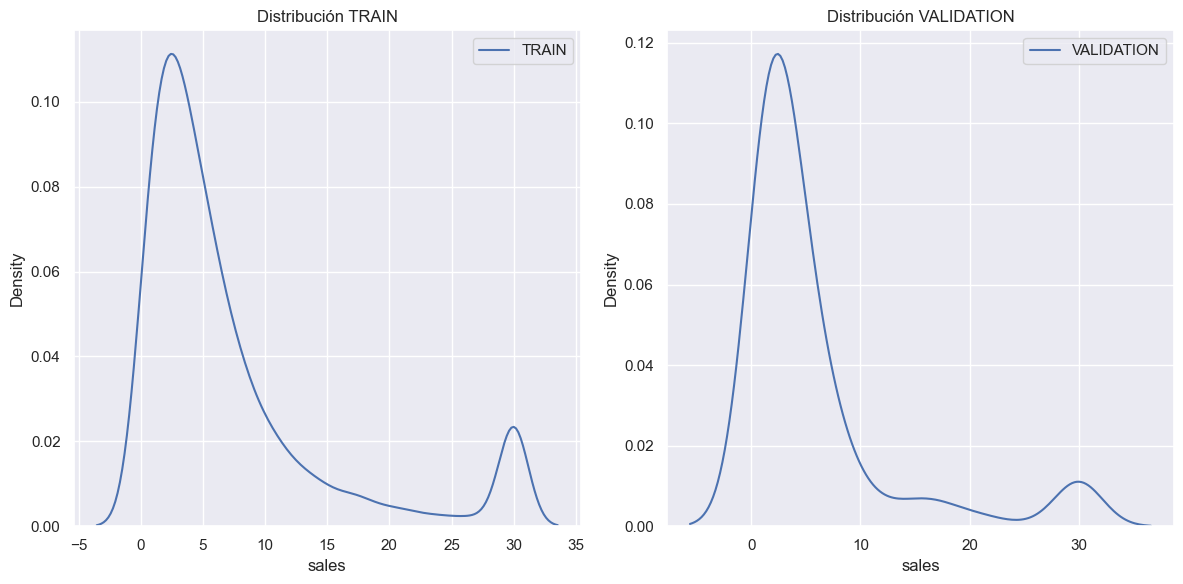

In [862]:
# Distribucion de target en train y validación
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.kdeplot(Y_train, ax=axes[0], label='TRAIN')
axes[0].set_title('Distribución TRAIN')
axes[0].legend()

sns.kdeplot(Y_valida, ax=axes[1], label='VALIDATION')
axes[1].set_title('Distribución VALIDATION')
axes[1].legend()

plt.tight_layout()
plt.show()


# Model Train

In [863]:
model = xgb.XGBRegressor(seed=175)

model.fit(
     X_train,
     Y_train,
     eval_metric = "rmse", 
     eval_set = [(X_train, Y_train), (X_valida, Y_valida)],  
     verbose = True,
     early_stopping_rounds = 15
     )

[0]	validation_0-rmse:6.28884	validation_1-rmse:5.85289
[1]	validation_0-rmse:5.26856	validation_1-rmse:4.77905
[2]	validation_0-rmse:4.64176	validation_1-rmse:4.07929
[3]	validation_0-rmse:4.26583	validation_1-rmse:3.67798
[4]	validation_0-rmse:4.02744	validation_1-rmse:3.42890
[5]	validation_0-rmse:3.88027	validation_1-rmse:3.27446
[6]	validation_0-rmse:3.77286	validation_1-rmse:3.18319
[7]	validation_0-rmse:3.68712	validation_1-rmse:3.14132
[8]	validation_0-rmse:3.61912	validation_1-rmse:3.14565
[9]	validation_0-rmse:3.53796	validation_1-rmse:3.11765
[10]	validation_0-rmse:3.48758	validation_1-rmse:3.14010
[11]	validation_0-rmse:3.44217	validation_1-rmse:3.11559
[12]	validation_0-rmse:3.38507	validation_1-rmse:3.11402
[13]	validation_0-rmse:3.34638	validation_1-rmse:3.12167
[14]	validation_0-rmse:3.32672	validation_1-rmse:3.12136
[15]	validation_0-rmse:3.28339	validation_1-rmse:3.10158
[16]	validation_0-rmse:3.25053	validation_1-rmse:3.10999
[17]	validation_0-rmse:3.21605	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Features Importance

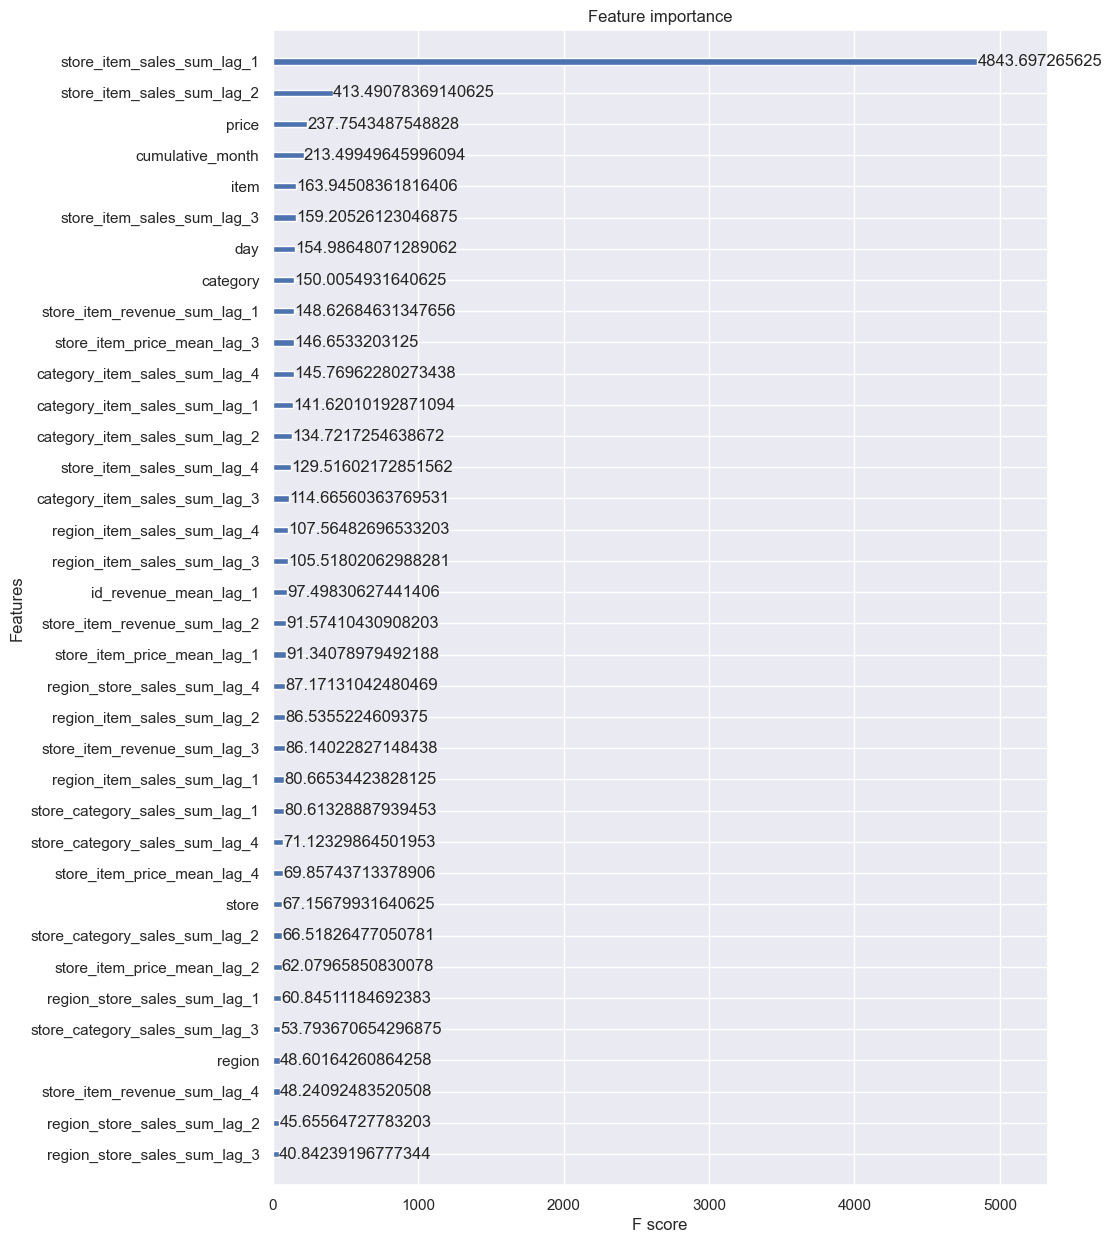

In [864]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

# Model Predict

In [865]:

Y_train_predict = model.predict(X_train).clip(0,30)
Y_valida_predict = model.predict(X_valida).clip(0,30)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_897
Validation RMSE: 3_068


# Model Evaluations

### Evaluación del Error

RMSE: 3.0678
MAE: 1.9517
R2-Score: 82.71%


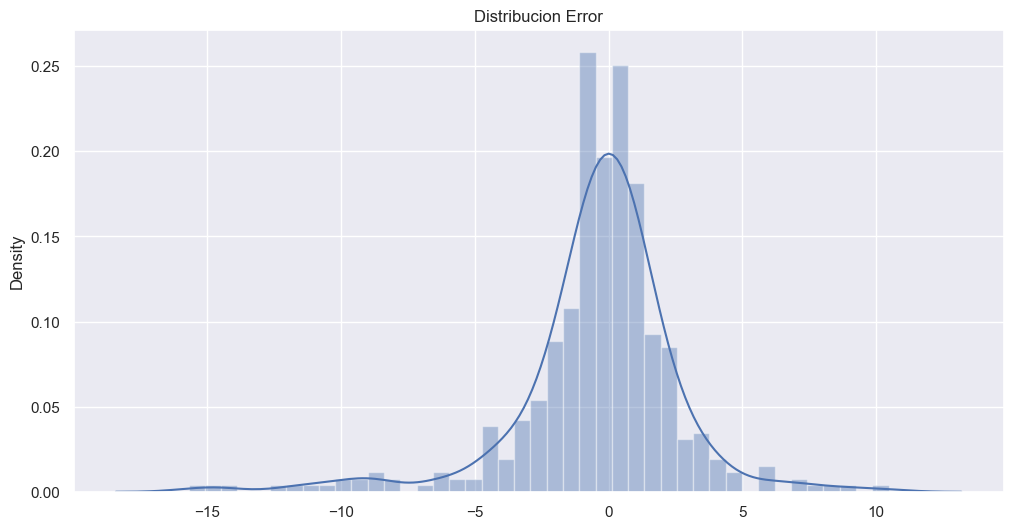

In [866]:
error = Y_valida_predict - Y_valida.values

mae = np.mean(np.abs(error))
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('R2-Score: {:.2%}'.format(r2_score(Y_valida, Y_valida_predict)))

sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

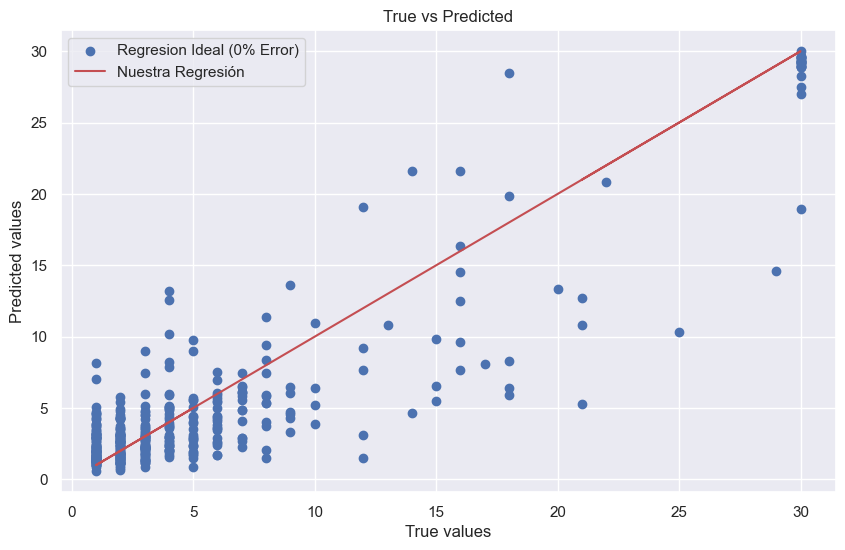

In [867]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(Y_valida, Y_valida_predict)
plt.plot(Y_valida, Y_valida,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

### Intervalo de confianza del Error

In [868]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 4.7 / -9.1


### Predición en datos de validacion

In [869]:
# Agregar la predicción como una nueva columna al DataFrame X_valida
X_valida.reset_index(inplace = True)
X_valida.head(2)
X_valida['sales_predict'] = Y_valida_predict

In [870]:
X_valida.head()

,id,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,...,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4,store_item_price_mean_lag_1,store_item_price_mean_lag_2,store_item_price_mean_lag_3,store_item_price_mean_lag_4,sales_predict
0,12_11365,16,12,9,11365,995.680556,30,33,6835.000000,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.701740
1,12_11369,16,12,9,11369,1321.367605,30,33,24322.876190,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.920996
2,12_11370,16,12,9,11370,681.715341,30,33,12313.213287,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.339930
3,12_11373,16,12,9,11373,437.929115,30,33,8694.877792,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.617519
4,12_12231,16,12,49,12231,350.000000,30,33,350.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.860528


# Test Prediction

In [871]:
# Eliminar la columna 'sales' si está presente
if "sales" in X_test.columns:
    X_test.drop("sales", axis=1, inplace=True)

# Realizar la predicción
Y_test_predict = model.predict(X_test).clip(0,30)

# Agregar la predicción como una nueva columna al DataFrame X_test
X_test.reset_index(inplace = True)
X_test['sales'] = Y_test_predict
X_test.head(2)

,id,region,store,category,item,price,day,cumulative_month,id_revenue_mean_lag_1,store_item_sales_sum_lag_1,...,region_item_sales_sum_lag_4,store_item_revenue_sum_lag_1,store_item_revenue_sum_lag_2,store_item_revenue_sum_lag_3,store_item_revenue_sum_lag_4,store_item_price_mean_lag_1,store_item_price_mean_lag_2,store_item_price_mean_lag_3,store_item_price_mean_lag_4,sales
0,12_11365,16,12,9,11365,0.0,31,34,24312.785714,NaN,...,26.0,40284.562984,67474.082560,69078.742424,23892.619048,969.998385,1339.886776,979.404082,894.206349,9.190053
1,12_11369,16,12,9,11369,0.0,31,34,21881.300000,NaN,...,90.0,82573.214432,84963.898506,64727.773614,104473.842204,917.480160,944.043317,719.197485,1160.820469,7.682080


In [872]:
X_test.shape

(426, 38)